In [64]:
import base64
import io
import pickle
import numpy as np
import math
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
    raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm


TORCH VERSION: 2.0.1+cu117


Code is an amalgamation of https://arxiv.org/pdf/2101.08176 and https://github.com/TinyVolt/normalizing-flows/blob/main/1d_composing_flows/ComposableFlows1d.ipynb

# Parameter Setting

In [65]:
# Physics Params
E0 = 500            # Energy of Hard Process
Lambda_QCD = 0.2    # Lambda QCD
cutoff = 0.01      # Cutoff for minimum lambda, ~ LambdaQCD / E0


# Training Params
num_epochs = 1500
lr = .01
batch_size = 512
num_points = 50 # we define a prior on each point along the horizontal axis
                # eventually this should be made large

In [66]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
    print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


In [67]:
def grab(var):
    return var.detach().cpu().numpy()

## Define a prior distribution


Standard normal

In [68]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
        torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return logp
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)

# Define the flow

Very simple 1-dimensional layers


In [69]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal 

class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.ones(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (distribution.cdf(x) * weights).sum(dim=1)
        log_dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1).log()
        return z, log_dz_by_dx
    
    def reverse(self, z):

        z = z.view(-1,1)
        weights = self.weight_logits.softmax(dim=0).view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        x = distribution.icdf(z / weights.sum(dim=1, keepdim=True)).sum(dim=1)
        x = torch.nan_to_num(x)
        return x

class LogitTransform(nn.Module):
    def __init__(self, alpha):
        super(LogitTransform, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        x_new = (self.alpha/2 + (1-self.alpha)*x).to(torch_device)
        z = torch.log(x_new) - torch.log(1-x_new)
        log_dz_by_dx = torch.log(torch.FloatTensor([1-self.alpha]).to(torch_device)) - torch.log(x_new) - torch.log(1-x_new)
        return z, log_dz_by_dx
    
    def reverse(self, z):
        x_new = torch.sigmoid(z)
        x = (x_new - self.alpha/2) / (1-self.alpha)
        return x
        

class FlowComposable1d(nn.Module):
    def __init__(self, flow_models_list):
        super(FlowComposable1d, self).__init__()
        self.flow_models_list = nn.ModuleList(flow_models_list).to(torch_device)

    def forward(self, x):
        z, sum_log_dz_by_dx = x, 0
        for flow in self.flow_models_list:
            z, log_dz_by_dx = flow(z)
            sum_log_dz_by_dx += log_dz_by_dx
        return z, sum_log_dz_by_dx
    
    def reverse(self, z):
        x = z
        for flow in reversed(self.flow_models_list):
            x = flow.reverse(x)
        return x

In [70]:
# Loss function

# # toy model
# def target_logp_order1(x): # 1st order approximation to the function

#     target_p = 1.5*(-x**2 + 1)

#     return torch.log(target_p)
# # """
def calc_dkl(logp, logq):
    return (logq - logp).mean() # reverse KL, assuming samples from q

# Define the probability density 

In [71]:
def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def target_logp_order1(x): # 1st order approximation to the function

    alpha_s_scale = alpha_s(x * E0) # GeV
    C_F = 4/3
    C_A = 3
    
    p_order1 = -(alpha_s_scale * C_F / (1 * np.pi)) * torch.log(x ) / x
        
    p_order1[x < cutoff] = 0

    # # normalize so the integral is 1
    # dx = x[1] - x[0]
    # p_order1 = p_order1 / p_order1.sum()  / dx
        
    log_p_order1 = torch.log(p_order1)
        
    

    return torch.nan_to_num(log_p_order1, nan = 0.0)

# # """
# # toy model
# def target_logp_order1(x): # 1st order approximation to the function

#     target_p = 1.5*(-x**2 + 1)

#     return torch.log(target_p)
# # """

# Model Initialization and Training

In [78]:
def initialize_model():

    # Initialize the prior
    prior = SimpleNormal(torch.zeros(num_points), torch.ones(num_points))

    # Initialize the model
    # Model archutecture not optimized at all
    flow_models_list = [Flow1d(2), LogitTransform(0.1), Flow1d(2), LogitTransform(0.1), Flow1d(2)]
    flow = FlowComposable1d(flow_models_list)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

    return flow, optimizer, prior


def train_model(lambda_star):

    train_losses = []
    flow, optimizer, prior = initialize_model()


    for epoch in tqdm(range(num_epochs)):


        # Generate a bunch of random samples xs, calculate p(xs)
        xs = torch.rand((batch_size, num_points)).to(torch_device)
        log_p = target_logp_order1(xs)

        # Calculate q(xs) using the reverse flow
        zs_from_xs = flow.reverse(xs)
        print(zs_from_xs)
        log_q = prior.log_prob(zs_from_xs)
        x_prime, logJ = flow(zs_from_xs)
        print(x_prime.shape, xs.shape)
        print(log_q.shape, logJ.shape, log_p.shape)
        log_q = log_q - logJ

        


        # Weighted KL divergence
        p = torch.exp(log_p)
        loss = torch.mean(p * (log_p - log_q))

        
        
        loss.backward()
        optimizer.step()
            
        train_losses.append(grab(loss))


    return flow, train_losses



In [79]:
lambda_stars = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
flows = []
train_losses = []

for lambda_star in lambda_stars:
    flow, train_loss = train_model(lambda_star)
    flows.append(flow)
    train_losses.append(train_loss)



  0%|          | 0/1500 [00:00<?, ?it/s]

tensor([0.0000, 1.5437, 0.0000,  ..., 1.6410, 1.6410, 1.6410],
       grad_fn=<NanToNumBackward0>)
torch.Size([25600]) torch.Size([512, 50])
torch.Size([25600, 50]) torch.Size([25600]) torch.Size([512, 50])


RuntimeError: The size of tensor a (50) must match the size of tensor b (25600) at non-singleton dimension 1

In [76]:
plt.figure()

for i, lambda_star in enumerate(lambda_stars[::-1]):
    plt.plot(train_losses[i], label = f"lambda_star = {lambda_star}", color = (i/len(lambda_stars), 0, 0))
    print(f"lambda_star = {lambda_star}, losses = {train_losses[i]}")

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Train loss")
plt.yscale('log')
plt.show()

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

NameError: name 'flow' is not defined

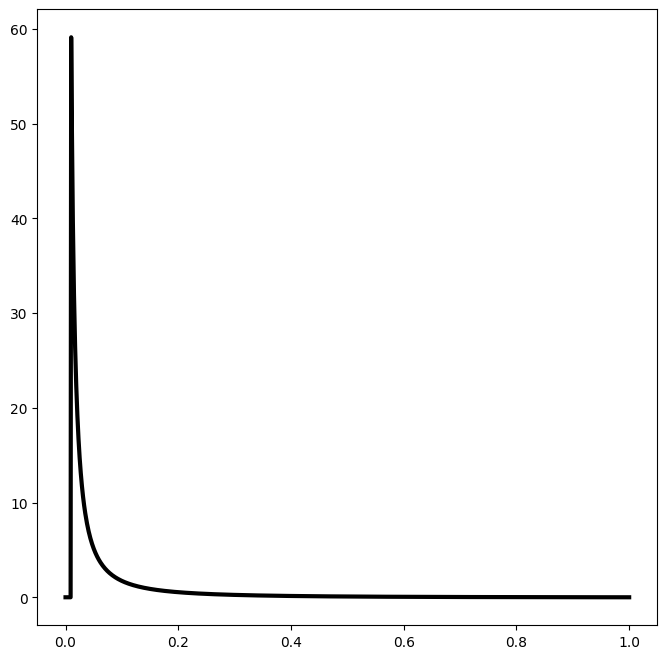

In [77]:
# plot output

for (i, lambda_star) in enumerate(lambda_stars):

    x_test = torch.linspace(0, 1, 1000)


    plt.figure(figsize = (8,8))

    # plot the target
    y_test = np.exp(grab(target_logp_order1(x_test.to(torch_device)))) 
    y_test = y_test / np.sum(y_test) / (x_test[1] - x_test[0]) 
    plt.plot(grab(x_test), y_test , label = "Leading Order Target", color = "black", lw = 3)

    # plot transformed prior
    prior = SimpleNormal(torch.zeros(num_points), torch.ones(num_points))
    x = prior.sample_n(batch_size).to(torch_device) # shape x: (batch_size, num_points)    
    x, logJ = flow(x)
    # need to reshape the outputs match those from the previous step
    x = grab(x.reshape(-1,1) )


    plt.hist(x, bins = np.linspace(0, 1, 100), density = True, label = "Learned Samples", histtype='step', color = "red", lw = 3)


    # Plot the samples as a baseline
    np_angularities = np.load("normalized_angularity.npy")
    plt.hist(np_angularities, bins = np.linspace(0, 1, 100), density = True, label = "Pythia Samples", histtype='step', color = "pink", lw = 3)

    # Vertical line at lambda_star
    plt.axvline(lambda_star, color = "black", linestyle = "--", label = r"$\lambda^*$")

    plt.yscale("log")
    plt.legend(frameon = False)
    plt.show()



